# Installations

In [1]:
# %pip install "opencv-python-headless<4.3"
# %pip install cellpose
# %pip install cytoself

# %pip install adjustText

# %pip install --upgrade scikit-image

# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random
from model import load_data, get_analytics
from cytoself_custom import plot_umap, calc_umap_embvec, plot_feature_spectrum_from_image
from synthetic_multiplexing import multiplex
from metrics import plot_boostrapping, calc_bootstrapping, plot_metrics
from explainability import generate_images, plot_clusters_distance_heatmap
from utils import get_colors_dict
from sklearn.metrics.pairwise import euclidean_distances
import seaborn as sns

import os
import config
from config import SEED, PRETRAINED_MODEL_PATH, MODEL_PATH, METRICS_FOLDER, METRICS_MATCH_PATH,METRICS_RANDOM_PATH, MICROGLIA_MARKERS


np.random.seed(SEED)
random.seed(SEED)

%reload_ext autoreload
%autoreload 2
%aimport

In /home/labs/hornsteinlab/noamru/anaconda3/envs/cytoself4/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/labs/hornsteinlab/noamru/anaconda3/envs/cytoself4/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/labs/hornsteinlab/noamru/anaconda3/envs/cytoself4/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/labs/hornsteinlab/noamru/anaconda3/envs/cytoself4/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was dep

Modules to reload:
all-except-skipped

Modules to skip:



In [3]:
imgself_wt_model_path = os.path.join("./models", "microglia_model.h5") #MODEL_PATH
imgself_all_model_path = os.path.join("./models", "microglia_all_lines_ep0023.h5") #MODEL_PATH

input_folders = ["./data/processed/microglia"]


# Figure 4

## Ranking markers (ALS) (+plot) - only test data

In [4]:
images_wt, labels_wt, labels_changepoints_wt, markers_order_wt = load_data(input_folders, markers=MICROGLIA_MARKERS, \
                                                                condition_l=False, type_l=True,\
                                                                    split_by_set=True,
                                                                    set_type = 'test',
                                                                    split_by_set_include=[("WT", "unstressed")])

# images_all, labels_all, labels_changepoints_all, markers_order_all = load_data(input_folders, markers=MICROGLIA_MARKERS, \
#                                                                 condition_l=False, type_l=True,\
#                                                                     split_by_set=True,
#                                                                     set_type = 'test')

#########################################################
########### Splitting by set! (test) #############
#########################################################
Input folder: ./data/processed/microglia
Input subfolder: ANXA11
Filepath: ./data/processed/microglia/FUS/unstressed/ANXA11/221002_iNDI_MG_FUS_unstressed-SCNA_ANXA11_DAPI_FUS.tif_processed
Input subfolder: CD41
Filepath: ./data/processed/microglia/FUS/unstressed/CD41/220929_iNDI_MG_FUS_unstressed-SQSTM1_FMRP_CD41_DAPI_FUS.tif_processed
Input subfolder: CLTC
Filepath: ./data/processed/microglia/FUS/unstressed/CLTC/220930_iNDI_MG_FUS_unstressed-PSD95_CLTC_phalloidin_DAPI_FUS.tif_processed
Input subfolder: Calreticulin
Filepath: ./data/processed/microglia/FUS/unstressed/Calreticulin/221003_iNDI_MG_FUS_unstressed-LAMP1_Calreticulin_DAPI_FUS.tif_processed
Input subfolder: DAPI
Filepath: ./data/processed/microglia/FUS/unstressed/DAPI/2200921_iNDI_MG_FUS_unstressed-G3BP1_KIF5A_TIA1_DAPI_FUS.tif_processed
Filepath: ./data/process

In [5]:
panel_id = "Ranking markers (ALS)"

def ranking_markers_als(analytics,labels):
    X = analytics.model.embvec[1]
    X = X.reshape(X.shape[0], -1)
    print(X.shape)

    # Setting clusters_centers as the median of all images of specific marker+cond
    labels_s = pd.Series(labels.reshape(-1,))

    labels_unique = labels_s.unique()
    clusters_median = np.zeros((len(labels_unique), X.shape[1]))
    for j, l in enumerate(labels_unique):
        ii = labels_s[labels_s.str.startswith(l)].index.tolist()
        current_x = X[ii, :].copy()
        clusters_median[j] = np.median(current_x, axis=0)

    # Calc dists
    dists = euclidean_distances(clusters_median)
    dists_df = pd.DataFrame(dists, index=labels_unique, columns=labels_unique)

    dists_df_copy = dists_df.copy()
    markers = np.unique([m.split("_")[0] for m in dists_df_copy.index.to_list()])
    distances_for_marker_WT = {m:None for m in markers}
    distances_for_marker_ALS = distances_for_marker_WT.copy()

    for ind in dists_df_copy.index:
        m, cell_line = ind.split('_')
        cols_with_current_cellline = dists_df_copy.columns.str.contains(f"{m}_{cell_line}")
        cols_with_current_marker = dists_df_copy.columns.str.contains(f"{m}_")
        if cell_line == "WT":
            vals = dists_df_copy.loc[cols_with_current_marker & cols_with_current_cellline,
                                 cols_with_current_marker & ~cols_with_current_cellline]
            distances_for_marker_WT[m] = vals.mean(axis=1).values[0]
        else:
            if distances_for_marker_ALS[m] is not None:
                continue
            cols_with_WT = dists_df_copy.columns.str.contains(f"{m}_WT")
            vals = dists_df_copy.loc[cols_with_current_marker & ~cols_with_WT,
                                 cols_with_current_marker & ~cols_with_WT]
            distances_for_marker_ALS[m] = np.sum(np.triu(vals.to_numpy())) * 1.0 / (vals.shape[0])

    df_WT = pd.DataFrame.from_dict(distances_for_marker_WT, orient='index')
    df_ALS = pd.DataFrame.from_dict(distances_for_marker_ALS, orient='index')

    merged = pd.merge(df_WT, df_ALS, left_index=True, right_index=True)
    merged.columns = ["WT", "ALS"]
    merged.sort_values(by=["WT","ALS"], ascending=[False, True],inplace=True)
    return merged


In [6]:
# imgself trained on wt
analytics_imgself_wt = get_analytics(images_wt, labels_wt, model_path=imgself_wt_model_path)
analytics_imgself_wt.model.calc_embvec(analytics_imgself_wt.data_manager.test_data)
ranked_markers_als_wt=ranking_markers_als(analytics_imgself_wt,labels_wt)
print(ranked_markers_als_wt)

X, y:
(15348, 100, 100, 2) (15348,)
DAPI_FUS       1779
DAPI_TDP43     1757
DAPI_OPTN      1250
TIA1_TDP43      235
KIF5A_TDP43     235
               ... 
PML_WT            9
SCNA_WT           7
ANXA11_WT         7
IL18RAP_WT        6
pNFKB_WT          6
Length: 104, dtype: int64
Creating the model
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2022-12-20 09:27:23 WARNING From /home/labs/hornsteinlab/noamru/anaconda3/envs/cytoself4/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2022-12-20 09:27:29 WARNING From /home/labs/hornsteinlab/noamru/anaconda3/envs/cytoself4/lib/python3.7/site-packages/tensorflow_core/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




All files will be saved at model_outputs/


Loading weights


2022-12-20 09:27:33 WARNING OMP_NUM_THREADS is no longer used by the default Keras config. To configure the number of threads, use tf.config.threading APIs.
2022-12-20 09:27:33.558535: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-12-20 09:27:33.577831: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:8b:00.0
2022-12-20 09:27:33.579020: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-12-20 09:27:33.626356: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-12-20 09:27:33.666703: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2022-12-20 09:27:33.690490: I tensorflow/stre

./models/microglia_model.h5
is loaded.
Ground truth:
['ANXA11_FUS' 'ANXA11_OPTN' 'ANXA11_TDP43' 'ANXA11_WT' 'CD41_FUS'
 'CD41_OPTN' 'CD41_TDP43' 'CD41_WT' 'CLTC_FUS' 'CLTC_OPTN' 'CLTC_TDP43'
 'CLTC_WT' 'Calreticulin_FUS' 'Calreticulin_OPTN' 'Calreticulin_TDP43'
 'Calreticulin_WT' 'DAPI_FUS' 'DAPI_OPTN' 'DAPI_TDP43' 'DAPI_WT'
 'DCP1A_FUS' 'DCP1A_OPTN' 'DCP1A_TDP43' 'DCP1A_WT' 'FMRP_FUS' 'FMRP_OPTN'
 'FMRP_TDP43' 'FMRP_WT' 'FUS_FUS' 'FUS_OPTN' 'FUS_TDP43' 'FUS_WT'
 'G3BP1_FUS' 'G3BP1_OPTN' 'G3BP1_TDP43' 'G3BP1_WT' 'GM130_FUS'
 'GM130_OPTN' 'GM130_TDP43' 'GM130_WT' 'IL18RAP_FUS' 'IL18RAP_OPTN'
 'IL18RAP_TDP43' 'IL18RAP_WT' 'KIF5A_FUS' 'KIF5A_OPTN' 'KIF5A_TDP43'
 'KIF5A_WT' 'LAMP1_FUS' 'LAMP1_OPTN' 'LAMP1_TDP43' 'LAMP1_WT' 'NCL_FUS'
 'NCL_OPTN' 'NCL_TDP43' 'NCL_WT' 'NEMO_FUS' 'NEMO_OPTN' 'NEMO_TDP43'
 'NEMO_WT' 'NONO_FUS' 'NONO_OPTN' 'NONO_TDP43' 'NONO_WT' 'PEX14_FUS'
 'PEX14_OPTN' 'PEX14_TDP43' 'PEX14_WT' 'PML_FUS' 'PML_OPTN' 'PML_TDP43'
 'PML_WT' 'PSD95_FUS' 'PSD95_OPTN' 'PSD95_TDP43' 'P

2022-12-20 09:27:39.147336: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-12-20 09:27:39.335402: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-12-20 09:27:40.291006: W tensorflow/stream_executor/cuda/redzone_allocator.cc:312] Not found: ./bin/ptxas not found
Relying on driver to perform ptx compilation. This message will be only logged once.


15348/15348 [==============================] - 14s 893us/sample
(15348, 9216)
                     WT        ALS
pNFKB         40.169713  14.895795
PML           37.819327  18.556261
KIF5A         37.734875  17.803617
IL18RAP       31.743093  14.265073
TIA1          28.219541  30.382854
TOMM20        26.705614  13.331869
syto12        26.237712  13.443584
G3BP1         24.226643  14.316207
FMRP          22.728640  16.876407
CLTC          21.577134  14.251127
NONO          20.704586  14.192820
DCP1A         19.865836  14.927628
ANXA11        19.269096  12.754893
NEMO          19.219544  11.687462
CD41          18.977014  13.994299
SCNA          18.515457  12.059781
PEX14         18.167187  17.843502
LAMP1         17.798777  13.799275
SQSTM1        17.380152  15.154188
Calreticulin  17.203341  13.179529
phalloidin    15.521568  10.330164
NCL           14.509758  12.808775
GM130         14.253384  13.966497
DAPI          13.889867   8.359384
PSD95         13.326403  10.628367
FUS         

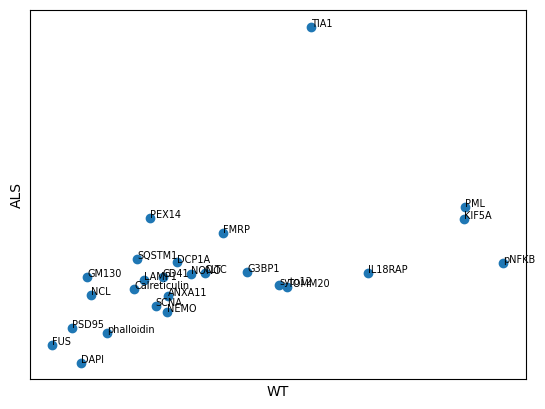

In [7]:
# plot wt
#merged_norm = pd.DataFrame([(ranked_markers_als_wt[col]-ranked_markers_als_wt[col].mean())/ranked_markers_als_wt[col].std()
#                            for col in ranked_markers_als_wt.columns]).T
merged_scaled = (ranked_markers_als_wt - ranked_markers_als_wt.min(axis=0)) / (ranked_markers_als_wt.max(axis=0) - ranked_markers_als_wt.min(axis=0))

plt.scatter(merged_scaled.loc[:,'WT'], merged_scaled.loc[:,'ALS'])
for i in range(merged_scaled.shape[0]):
    plt.annotate(merged_scaled.index[i], (merged_scaled.iloc[i]['WT'], merged_scaled.iloc[i]['ALS']),fontsize=7)
plt.xlabel('WT')
plt.ylabel('ALS')
plt.xticks([])
plt.yticks([])
plt.show()

In [8]:
#Ranking by cell line

X = analytics_imgself_wt.model.embvec[1]
X = X.reshape(X.shape[0], -1)
print(X.shape)

# Setting clusters_centers as the median of all images of specific marker+cond
labels_s = pd.Series(labels_wt.reshape(-1,))

labels_unique = labels_s.unique()
clusters_median = np.zeros((len(labels_unique), X.shape[1]))
for j, l in enumerate(labels_unique):
    ii = labels_s[labels_s.str.startswith(l)].index.tolist()
    current_x = X[ii, :].copy()
    clusters_median[j] = np.median(current_x, axis=0)

# Calc dists
dists = euclidean_distances(clusters_median)
dists_df = pd.DataFrame(dists, index=labels_unique, columns=labels_unique)

dists_df_cols, dists_df_ind = dists_df.columns, dists_df.index
# To numpy for scaling accross all columns!
dists_df_np = dists_df.to_numpy()
dists_df_np_scaled = (dists_df_np-dists_df_np.min()) / (dists_df_np.max() - dists_df_np.min())
# Back to dataframe after scaling
dists_df_scaled = pd.DataFrame(dists_df_np_scaled, columns=dists_df_cols, index=dists_df_ind)

markers = np.unique([m.split("_")[0] for m in dists_df.index.to_list()])

wt_hits = dists_df_scaled.index.str.contains(config.TERM_WT)
for line in [config.TERM_TDP43, config.TERM_FUS, config.TERM_OPTN]:
    line_hits = dists_df_scaled.columns.str.contains(line)
    rankings = dists_df_scaled.loc[wt_hits, line_hits]
    rankings = rankings.loc[sorted(rankings.index), sorted(rankings.columns)]
    rankings = pd.Series(np.diag(rankings), index=rankings.index).sort_values(ascending=False)
    print(line)
    print(rankings)
    print('---')

# plt.figure(figsize=(20,20))
# sns.clustermap(dists_df_scaled, yticklabels=True, xticklabels=True)
# plt.show()

# for m in markers:
#     logging.info(f"[{fig_id} {panel_id}] {m}")
#     cols_with_current_marker = dists_df_scaled.columns.str.contains(f"{m}_")
#     d = dists_df_scaled.loc[cols_with_current_marker, cols_with_current_marker]
#     d = d.sort_index(axis=0).sort_index(axis=1)
#     sns.heatmap(d)
#     plt.title(m)
#     plt.show()


(15348, 9216)
_TDP43
KIF5A_WT           0.609434
pNFKB_WT           0.598042
PML_WT             0.550710
IL18RAP_WT         0.466811
TOMM20_WT          0.445260
syto12_WT          0.436652
TIA1_WT            0.420478
G3BP1_WT           0.350541
FMRP_WT            0.323714
CLTC_WT            0.310904
CD41_WT            0.308457
NEMO_WT            0.300201
ANXA11_WT          0.292999
NONO_WT            0.291186
LAMP1_WT           0.273757
DCP1A_WT           0.268266
SCNA_WT            0.268119
Calreticulin_WT    0.266433
SQSTM1_WT          0.257059
phalloidin_WT      0.237067
GM130_WT           0.236003
PEX14_WT           0.233955
PSD95_WT           0.203165
NCL_WT             0.198379
FUS_WT             0.189711
DAPI_WT            0.181049
dtype: float64
---
_FUS
pNFKB_WT           0.602703
KIF5A_WT           0.580822
PML_WT             0.518603
IL18RAP_WT         0.496937
TIA1_WT            0.455182
TOMM20_WT          0.401649
G3BP1_WT           0.378174
NONO_WT            0.374523
PEX

In [9]:
# # imgself trained on all lines
# analytics_imgself_all = get_analytics(images_all, labels_all, model_path=imgself_all_model_path)
# analytics_imgself_all.model.calc_embvec(analytics_imgself_all.data_manager.test_data)
# ranked_markers_als_all=ranking_markers_als(analytics_imgself_all,labels_all)
# print(ranked_markers_als_all)

In [10]:
# # Plot all lines
# # merged_norm = pd.DataFrame([(ranked_markers_als_all[col]-ranked_markers_als_all[col].mean())/ranked_markers_als_all[col].std()
# #                             for col in ranked_markers_als_all.columns]).T

# merged_scaled = (ranked_markers_als_all - ranked_markers_als_all.min(axis=0)) / (ranked_markers_als_all.max(axis=0) - ranked_markers_als_all.min(axis=0))

# plt.scatter(merged_scaled.loc[:,'WT'], merged_scaled.loc[:,'ALS'])
# for i in range(merged_scaled.shape[0]):
#     plt.annotate(merged_scaled.index[i], (merged_scaled.iloc[i]['WT'], merged_scaled.iloc[i]['ALS']))
# plt.xlabel('WT')
# plt.ylabel('ALS')
# plt.xticks([])
# plt.yticks([])
# plt.show()

## Ranking markers (ALS) (+plot) - data with train

In [11]:
# images, labels, labels_changepoints, markers_order = load_data(input_folders, markers=MICROGLIA_MARKERS, \
#                                                                 condition_l=False, type_l=True,\
#                                                                     split_by_set=False)

In [12]:
# # imgself trained on wt
# analytics_imgself_wt = get_analytics(images, labels, model_path=imgself_wt_model_path)
# analytics_imgself_wt.model.calc_embvec(analytics_imgself_wt.data_manager.test_data)
# ranked_markers_als_wt=ranking_markers_als(analytics_imgself_wt,labels)
# print(ranked_markers_als_wt)

# # plot wt
# #merged_norm = pd.DataFrame([(ranked_markers_als_wt[col]-ranked_markers_als_wt[col].mean())/ranked_markers_als_wt[col].std()
# #                            for col in ranked_markers_als_wt.columns]).T
# merged_scaled = (ranked_markers_als_wt - ranked_markers_als_wt.min(axis=0)) / (ranked_markers_als_wt.max(axis=0) - ranked_markers_als_wt.min(axis=0))

# plt.scatter(merged_scaled.loc[:,'WT'], merged_scaled.loc[:,'ALS'])
# for i in range(merged_scaled.shape[0]):
#     plt.annotate(merged_scaled.index[i], (merged_scaled.iloc[i]['WT'], merged_scaled.iloc[i]['ALS']))
# plt.xlabel('WT')
# plt.ylabel('ALS')
# plt.xticks([])
# plt.yticks([])
# plt.show()

In [13]:
# # imgself trained on all lines
# analytics_imgself_all = get_analytics(images, labels, model_path=imgself_all_model_path)
# analytics_imgself_all.model.calc_embvec(analytics_imgself_all.data_manager.test_data)
# ranked_markers_als_all=ranking_markers_als(analytics_imgself_all,labels)
# print(ranked_markers_als_all)

# # Plot all lines
# # merged_norm = pd.DataFrame([(ranked_markers_als_all[col]-ranked_markers_als_all[col].mean())/ranked_markers_als_all[col].std()
# #                             for col in ranked_markers_als_all.columns]).T

# merged_scaled = (ranked_markers_als_all - ranked_markers_als_all.min(axis=0)) / (ranked_markers_als_all.max(axis=0) - ranked_markers_als_all.min(axis=0))

# plt.scatter(merged_scaled.loc[:,'WT'], merged_scaled.loc[:,'ALS'])
# for i in range(merged_scaled.shape[0]):
#     plt.annotate(merged_scaled.index[i], (merged_scaled.iloc[i]['WT'], merged_scaled.iloc[i]['ALS']))
# plt.xlabel('WT')
# plt.ylabel('ALS')
# plt.xticks([])
# plt.yticks([])
# plt.show()